In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

manjilkarki_deepfake_and_real_images_path = kagglehub.dataset_download('manjilkarki/deepfake-and-real-images')
azizzz07_vit_model_path = kagglehub.dataset_download('azizzz07/vit-model')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install torch torchvision timm matplotlib seaborn scikit-learn tqdm


In [ ]:
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define the transformation for the test dataset
def get_transforms(augment=False):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Load the test dataset
def create_dataset(data_dir, batch_size=128):
    transform = get_transforms(augment=False)
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Load the test dataset
base_dir = "/kaggle/input/deepfake-and-real-images/Dataset"  # Adjust this to the actual path
test_ds = create_dataset(os.path.join(base_dir, "Test"))

# Class names
class_names = ["Deepfake", "Real"]


In [ ]:
# Load the pre-trained Vision Transformer model (ViT)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = timm.create_model('vit_base_patch16_224', img_size=256, pretrained=False, num_classes=2)

# Load the saved model state
checkpoint_path = '/kaggle/input/vit-model/ViT8576.pth'  # Path to the saved model
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)
print("Model Loaded Successfully")
model.eval()


<ipython-input-7-f528332efc6a>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


Model Loaded Successfully


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
# Evaluate on the test set
test_preds = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_ds:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Calculate test metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)

print('\nFinal Test Results:')
print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')



Final Test Results:
Accuracy: 0.8576
Precision: 0.8642
Recall: 0.8461
F1 Score: 0.8550


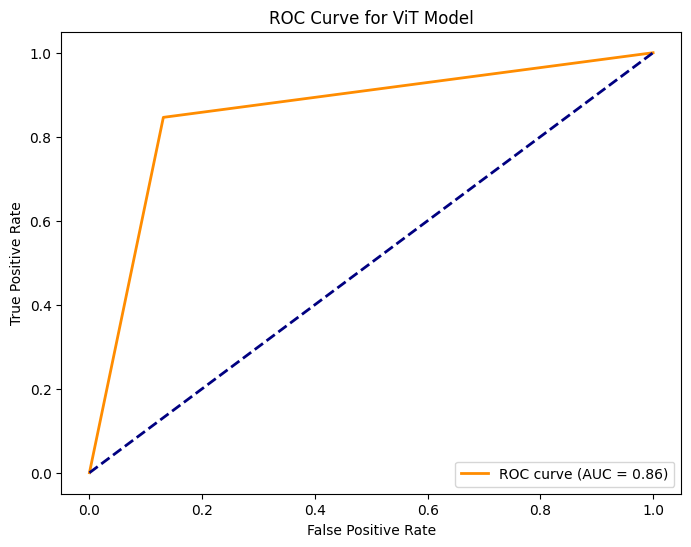

In [ ]:
# ======================
# ROC Curve
# ======================

from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ViT Model')
plt.legend(loc='lower right')
plt.show()


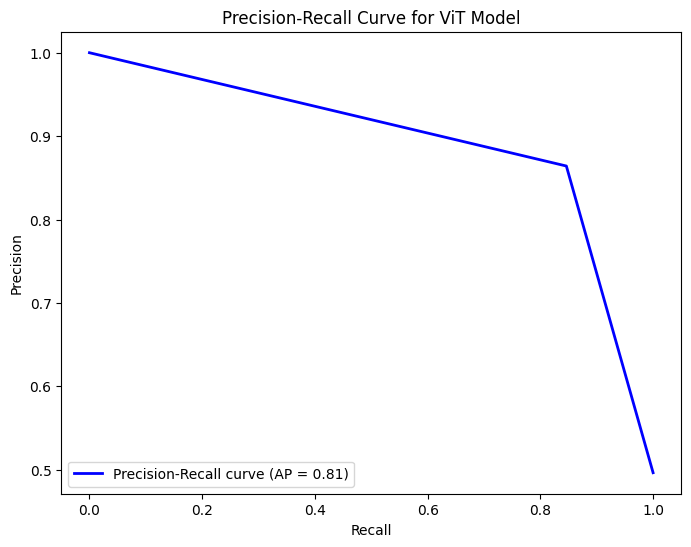

In [ ]:
# ======================
# Precision-Recall Curve
# ======================

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(test_labels, test_preds)
avg_precision = average_precision_score(test_labels, test_preds)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for ViT Model')
plt.legend(loc='lower left')
plt.show()


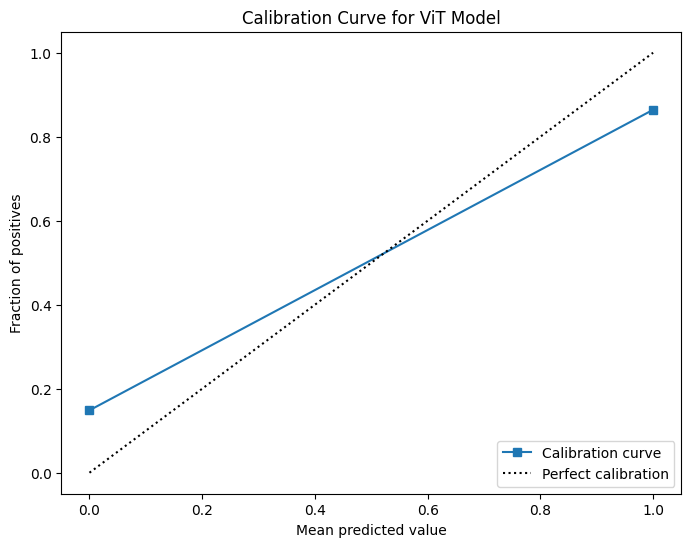

In [ ]:
# ======================
# Calibration Curve
# ======================

from sklearn.calibration import calibration_curve

fraction_of_positives, mean_predicted_value = calibration_curve(test_labels, test_preds, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Calibration curve')
plt.plot([0, 1], [0, 1], "k:", label="Perfect calibration")
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve for ViT Model')
plt.legend(loc='lower right')
plt.show()


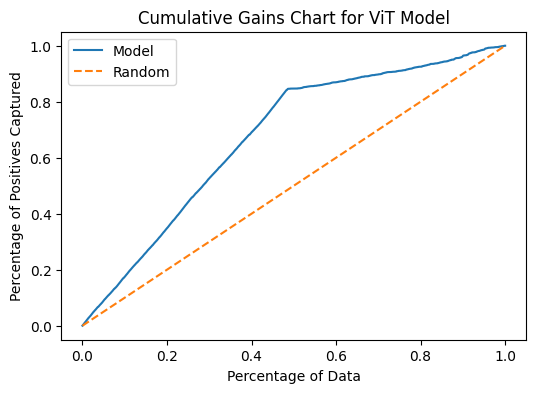

In [ ]:
# ======================
# Cummulative Gains Chart
# ======================

import pandas as pd

df = pd.DataFrame({'label': test_labels, 'pred': test_preds}).sort_values('pred', ascending=False).reset_index(drop=True)
df['cumulative_positive'] = df['label'].cumsum()
df['percentage_positive'] = df['cumulative_positive'] / df['label'].sum()
df['percentage_data'] = (df.index + 1) / len(df)

plt.figure(figsize=(6, 4))
plt.plot(df['percentage_data'], df['percentage_positive'], label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("Percentage of Data")
plt.ylabel("Percentage of Positives Captured")
plt.title("Cumulative Gains Chart for ViT Model")
plt.legend()
plt.show()


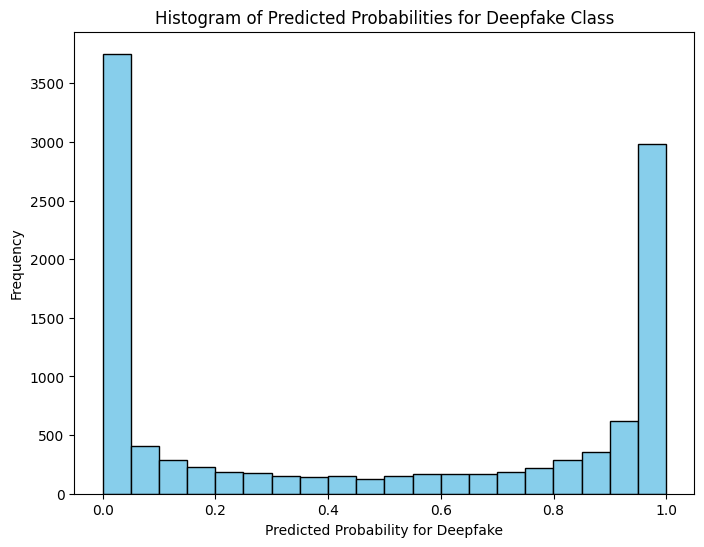

In [ ]:
# Generate predicted probabilities for the test set
test_probs = []

with torch.no_grad():
    for inputs, labels in test_ds:
        inputs, labels = inputs.to(device), labels.to(device)

        # Get the model's raw outputs
        outputs = model(inputs)

        # Apply softmax to get probabilities for each class
        probs = torch.softmax(outputs, dim=1)[:, 1]  # We are interested in the probability of the positive class (Deepfake)

        test_probs.extend(probs.cpu().numpy())

# Plot histogram of predicted probabilities for the positive class (Deepfake)
plt.figure(figsize=(8, 6))
plt.hist(test_probs, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Predicted Probabilities for Deepfake Class')
plt.xlabel('Predicted Probability for Deepfake')
plt.ylabel('Frequency')
plt.show()



Threshold: 0.3
Test Accuracy: 0.8572


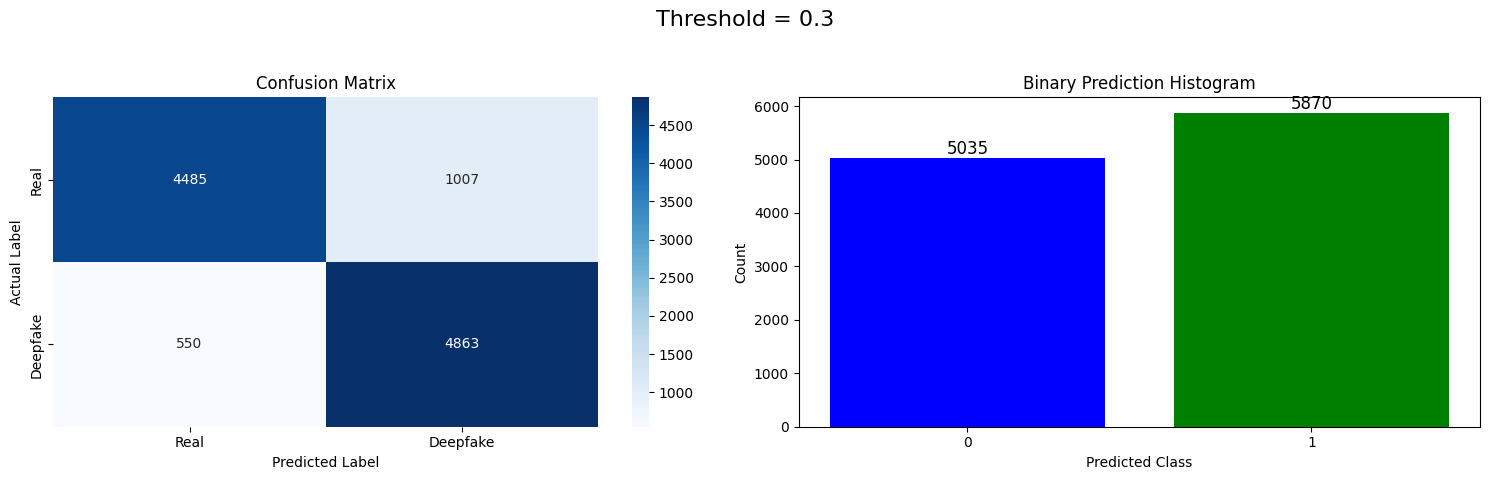


Threshold: 0.4
Test Accuracy: 0.8604


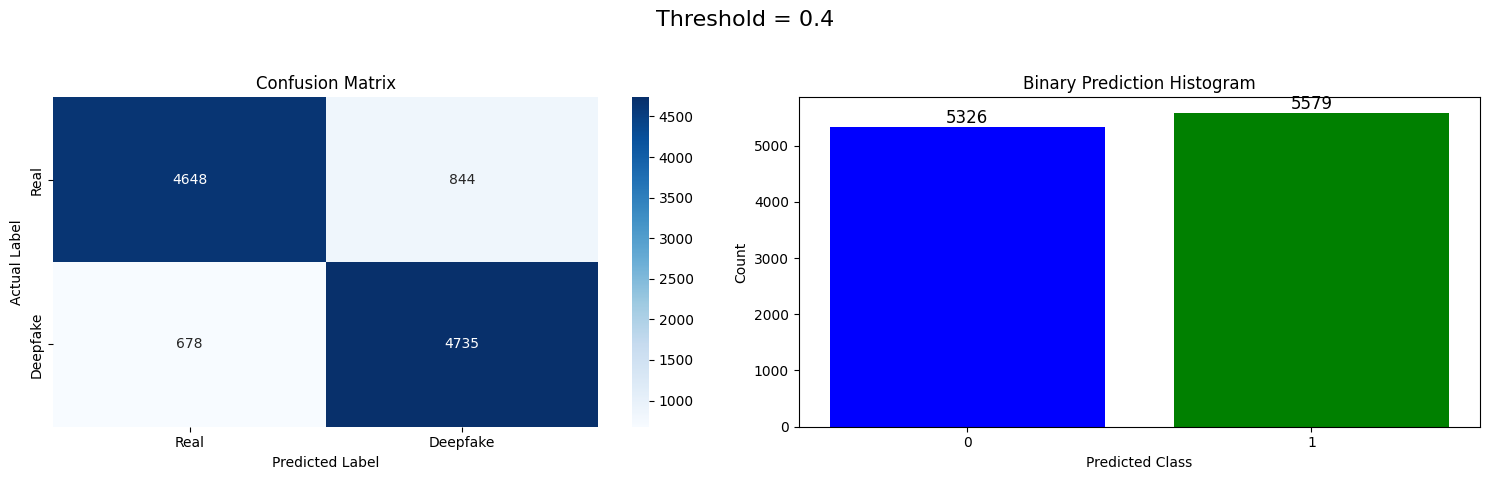


Threshold: 0.5
Test Accuracy: 0.8576


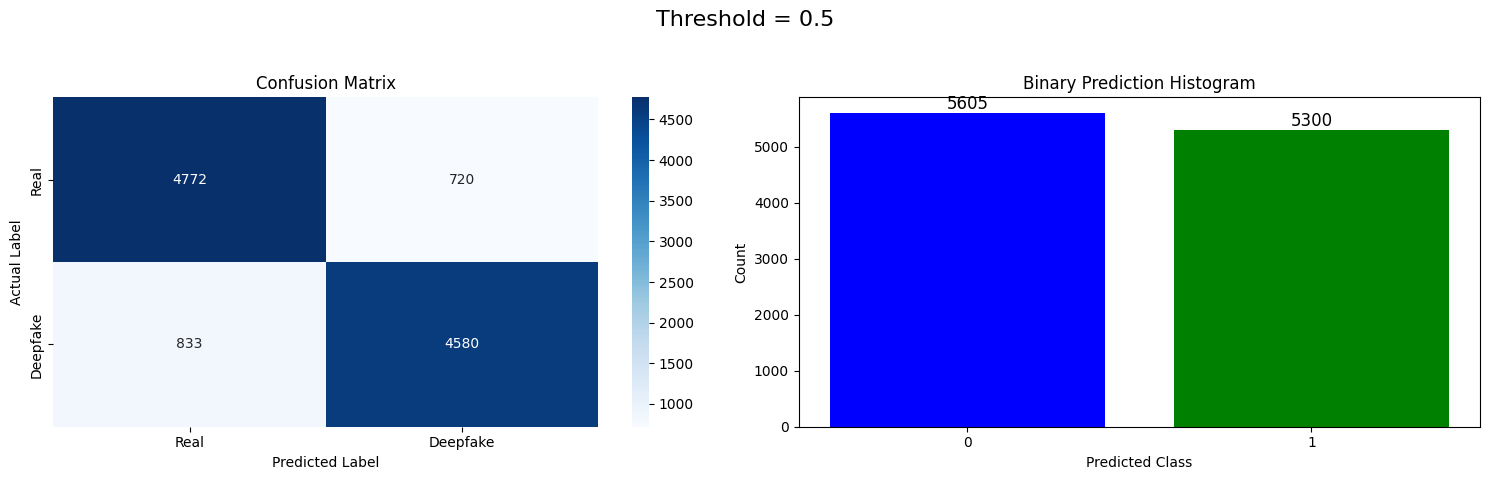


Threshold: 0.6
Test Accuracy: 0.8519


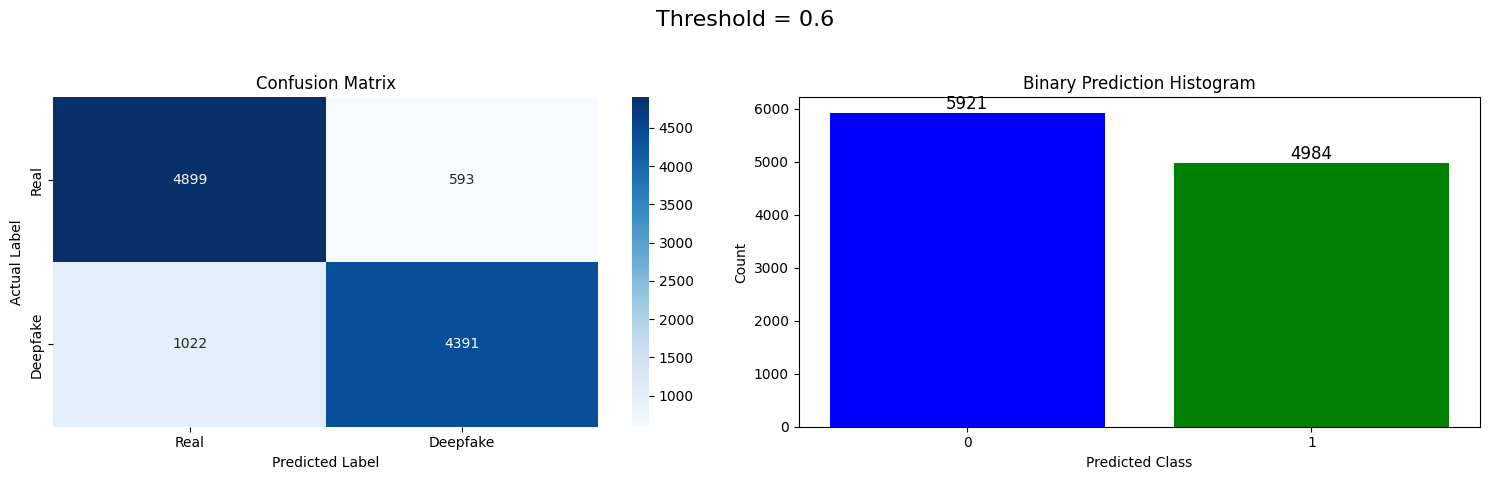


Threshold: 0.7
Test Accuracy: 0.8410


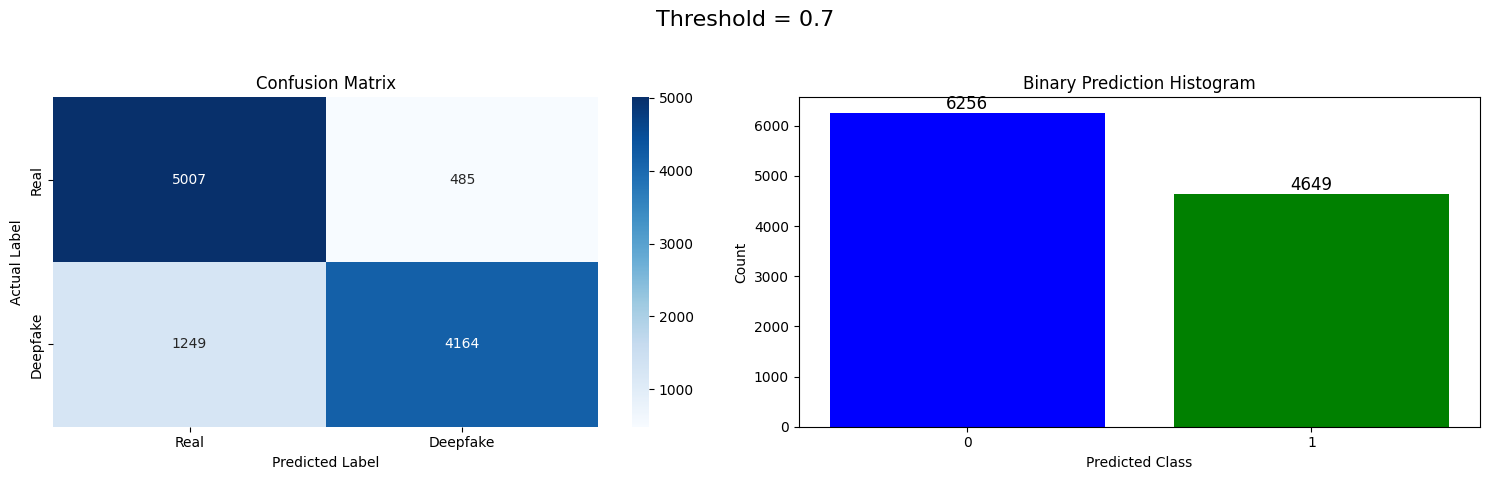

In [ ]:
# ======================
# Confusion Matrices and Accuracy for Different Thresholds
# ======================

# Define thresholds to evaluate
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# List to store results
results = []

for thresh in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    test_preds_binary = (np.array(test_probs) >= thresh).astype(int)
    test_labels_np = np.array(test_labels).astype(int)

    # Calculate accuracy for the current threshold
    test_accuracy = (test_preds_binary == test_labels_np).mean()

    # Print threshold and accuracy
    print(f"\nThreshold: {thresh}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Create a figure with 2 plots: Confusion Matrix and Binary Prediction Bar Chart
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(f"Threshold = {thresh}", fontsize=16)

    # Subplot 1: Confusion Matrix Heatmap
    cm = confusion_matrix(test_labels_np, test_preds_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Deepfake'],
                yticklabels=['Real', 'Deepfake'],
                ax=axs[0])
    axs[0].set_xlabel('Predicted Label')
    axs[0].set_ylabel('Actual Label')
    axs[0].set_title('Confusion Matrix')

    # Subplot 2: Bar Chart of Binary Predictions with Count Annotation
    unique, counts = np.unique(test_preds_binary, return_counts=True)
    axs[1].bar(unique, counts, color=['blue', 'green'])
    axs[1].set_xticks([0, 1])
    axs[1].set_xlabel('Predicted Class')
    axs[1].set_ylabel('Count')
    axs[1].set_title('Binary Prediction Histogram')

    # Annotate each bar with its count
    for i, count in zip(unique, counts):
        axs[1].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

